## 14<sup>th</sup> of April, 2020
## Benjamin Adam Catching
## Coronavirus Simulation
## Andino Lab

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd

Most of today has been used to update the github repo. The base layer of the simulation tested sheltering in place and mask usage. The asymptomatic vs. symptomatic transmission dynamic the simulation needs to be added on top of this, but this dynamic must first be calibrated to reflect real-world parameters (R<sub>o</sub>, incubation time...).  

First reintroduce the baseline model, then add the symptomatic/asymptomatic attribute each agent, signified by a 1 or 0. 

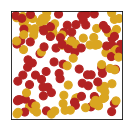

In [26]:
# Name the datafile
run_name = 'asympt_test_01'
dataname = '../../data/' + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,recovered,\
    infected with mask,susceptible with mask')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(100)

# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5
# Figure ratio
fig_rat = .2

# Number of steps
N_steps = 120
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .2

# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])

"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 14*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66

"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Firebrick'
agents['state'][0] = 'Infected'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1

"""Define the values of the display"""

# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """


    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j] == 0
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
            elif agent_j_infected or agent_j_exposed:
                agents['time'][j] += 1
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= .5:
                        agents['touch'][j] += 1
                        if agents['state'][j] == 'Infected' and agents['state'][k] == 'Susceptible':
                            if agents['symptomatic'][j] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif agents['state'][k] == 'Infected' and agents['state'][j] == 'Susceptible':
                            if agents['symptomatic'][k] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1

        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected) \
                 + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) \
                 + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
temp_name = run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
